# SWA Differences - SWI + SWISIN Experiments

In [5]:
#-------------------------- Standard Imports --------------------------#
%reload_ext autoreload
%autoreload 2
import kdephys as kde
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import acr
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots.mplstyle')

# ---------------------------- EXTRAS --------------------------------#
from acr.utils import swi_subs_exps, sub_probe_locations, sub_exp_types
import pingouin as pg
band_def = list(kde.utils.spectral.bands.keys())


In [6]:
# IMPORTANT PARAMETERS
# --------------------
REBOUND_LENGTH = '1h'
REL_STATE = 'NREM'

In [50]:
figs = '/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/plots_presentations_etc/temp'

# Slow-Wave Induction during Sleep Deprivation

In [88]:
fsd_df = pl.read_csv('data/stim_df.csv')
fsd_by_chan = fsd_df.filter(pl.col('Band')=='delta').groupby(['subject', 'channel', 'exp', 'store']).mean()
cut = fsd_by_chan.sort('Bandpower').filter(pl.col('Bandpower')<1.5)
good_chans = cut.groupby(['subject', 'exp', 'channel', 'store']).mean()
good_chans.filter((pl.col('subject')=='ACR_19') & (pl.col('exp')=='swi'))['channel'].unique().to_list()

[9, 10, 12, 14, 16]

In [89]:
# Gets us the channels that are relatively artifact-free for each subject and experiment
chans = {}
for sub in swi_subs_exps:
    chans[sub] = {}
    for exp in swi_subs_exps[sub]:
        chans[sub][exp] = good_chans.filter((pl.col('subject')==sub) & (pl.col('exp')==exp))['channel'].unique().to_list()


In [90]:
chans['ACR_20']['swisin'] = [9, 10, 11, 12, 13, 14, 15, 16]
chans['ACR_20']['swi'] = [9, 10, 11, 12, 13, 14, 15, 16]
chans['ACR_23']['swisin'] = [9, 10, 11, 12, 13, 14, 15, 16]
chans['ACR_23']['swi'] = [9, 10, 11, 12, 13, 14, 15, 16]

In [158]:
sd_df = pl.read_csv('data/stim_df.csv')

In [159]:
# this will get us a version of the stimulation df with only the clean channels
sd_df_clean = pl.DataFrame()
for sub in swi_subs_exps:
    for exp in swi_subs_exps[sub]:
        clean_chans = chans[sub][exp]
        clean_sub_exp = sd_df.filter(pl.col('subject') == sub).filter(pl.col('exp') == exp).filter(pl.col('channel').is_in(clean_chans))
        sd_df_clean = pl.concat([sd_df_clean, clean_sub_exp])

In [160]:
sd_exp_som = sd_df_clean.filter(pl.col('Band')=='delta').filter(pl.col('state')=='Wake-Good').filter(pl.col('exp_type') == ('som')) # only delta, wake, and experimental animals
sd_exp_means_som = sd_exp_som.groupby(['subject', 'exp', 'store']).mean().sort('Bandpower')
sd_exp_means_som = sd_exp_means_som.with_columns(exp_alias=pl.when(pl.col('exp')=='swi2').then('swi').otherwise(pl.col('exp')))

/tmp/ipykernel_2524961/1051586707.py:3: DeprecationWarning: in a future version, string input will be parsed as a column name rather than a string literal. To silence this warning, pass the input as an expression instead: `pl.lit('swi')`
  sd_exp_means_som = sd_exp_means_som.with_columns(exp_alias=pl.when(pl.col('exp')=='swi2').then('swi').otherwise(pl.col('exp')))


In [161]:
sd_exp_acr = sd_df_clean.filter(pl.col('Band')=='delta').filter(pl.col('state')=='Wake').filter(pl.col('exp_type') == ('exp')) # only delta, wake, and experimental animals
sd_exp_means_acr = sd_exp_acr.groupby(['subject', 'exp', 'store']).mean().sort('Bandpower')
sd_exp_means_acr = sd_exp_means_acr.with_columns(exp_alias=pl.when(pl.col('exp')=='swi2').then('swi').otherwise(pl.col('exp')))

/tmp/ipykernel_2524961/3326464930.py:3: DeprecationWarning: in a future version, string input will be parsed as a column name rather than a string literal. To silence this warning, pass the input as an expression instead: `pl.lit('swi')`
  sd_exp_means_acr = sd_exp_means_acr.with_columns(exp_alias=pl.when(pl.col('exp')=='swi2').then('swi').otherwise(pl.col('exp')))


In [162]:
sd_exp_means = pl.concat([sd_exp_means_som, sd_exp_means_acr])

In [163]:
sd_dex_means = sd_exp_means.to_pandas()

In [ ]:

new_sub = 40 # Need to do this so I can connect the individual data points within experiments
for subject in sd_dex_means.expmt('swi2').subject.unique():
    sd_dex_means.loc[(sd_dex_means.subject == subject) & (sd_dex_means['exp'] == 'swi2'), 'subject'] = f'ACR_{new_sub}'
    new_sub += 1

/tmp/ipykernel_2524961/1859555948.py:10: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=sd_dex_means.exp_names(), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['black', 'blue'], marker='o', size=18, ax=ax[0])
/tmp/ipykernel_2524961/1859555948.py:24: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=sd_dex_means.exp_names(), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['black', 'blue'], marker='o', size=18, ax=ax[1])


Text(0.5, 0.98, 'SWA During Photoinhibition')

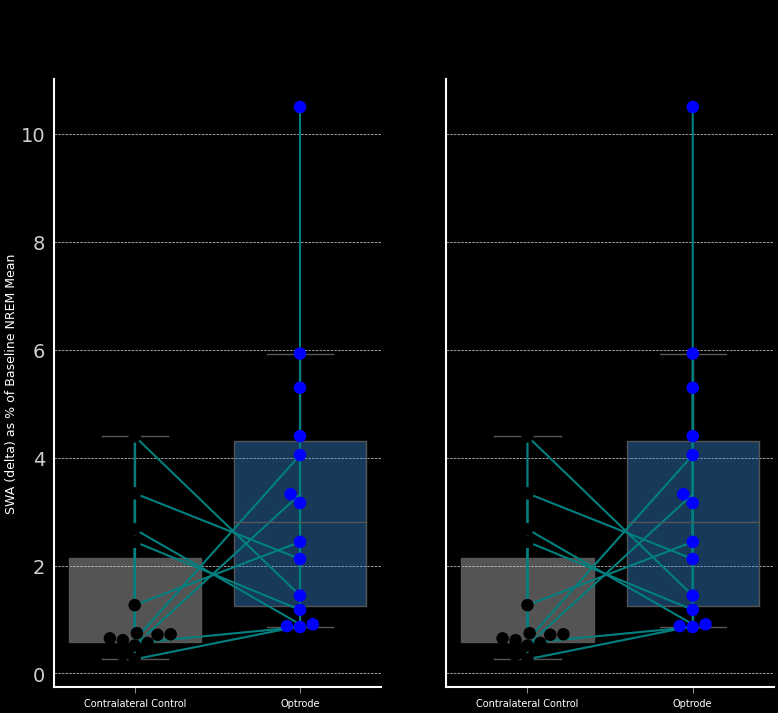

In [146]:
f, ax = plt.subplots(1, 2, figsize=(18, 15), sharey=True)


# OFF-INDUCTION
sns.boxplot(data=sd_dex_means.exp_als(), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['lightgray', 'dodgerblue'], fliersize=0, ax=ax[0])
for patch in ax[0].patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

sns.swarmplot(data=sd_dex_means.exp_als(), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['black', 'blue'], marker='o', size=18, ax=ax[0])
sns.lineplot(data=sd_dex_means.exp_als(), x='store', y='Bandpower', units='subject', estimator=None, color='teal', ax=ax[0], linewidth=3)

ax[0].set_xticklabels(['Contralateral Control', 'Optrode'])
ax[0].set_xlabel('')
#ax[0].set_title('OFF-Induction', fontsize=24)
ax[0].set_ylabel('SWA (delta) as % of Baseline NREM Mean')

# SINUSOIDAL
sns.boxplot(data=sd_dex_means.exp_als(), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['lightgray', 'dodgerblue'], fliersize=0, ax=ax[1])
for patch in ax[1].patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

sns.swarmplot(data=sd_dex_means.exp_als(), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['black', 'blue'], marker='o', size=18, ax=ax[1])
sns.lineplot(data=sd_dex_means.exp_als(), x='store', y='Bandpower', units='subject', estimator=None, color='teal', ax=ax[1], linewidth=3)

ax[1].set_xticklabels(['Contralateral Control', 'Optrode'])
ax[1].set_xlabel('')
#ax[1].set_title('Sinusoidal', fontsize=24)
ax[1].set_ylabel('')


# FIGURE-LEVEL
f.suptitle('SWA During Photoinhibition')
#ax[0].set_ylim(1.0, 3.0)
#ax[1].set_ylim(1.0, 3.0)

/tmp/ipykernel_2524961/556004015.py:41: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=sd_dex_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#e7dede', '#002aff'], marker='o', size=13, ax=ax)


Text(66.3888888888889, 0.5, 'SWA (delta) as % of Baseline NREM Mean')

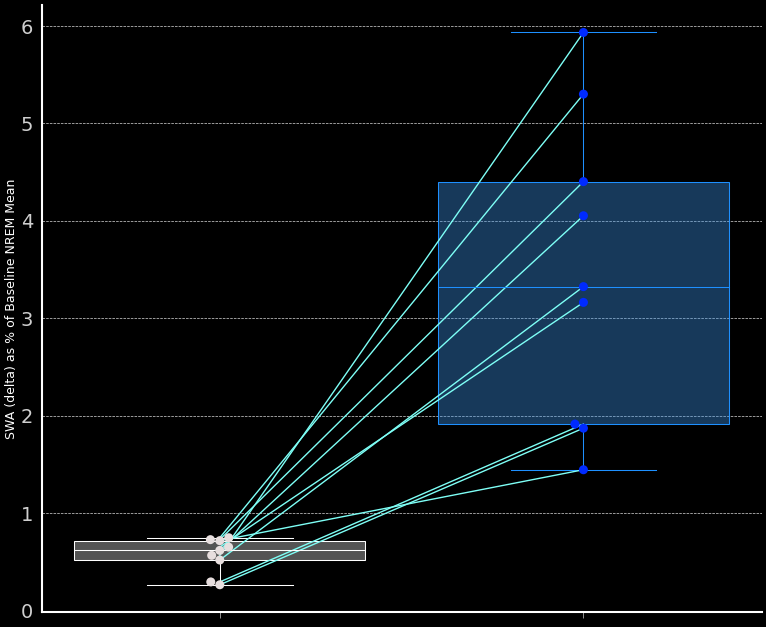

In [172]:
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots_dark.mplstyle')
sd_dex_means = sd_dex_means.loc[sd_dex_means['subject']!='ACR_14']
f, ax = plt.subplots(figsize=(18, 15), sharey=True)

sns.boxplot(
            x='store', 
            y='Bandpower',
            data=sd_dex_means.loc[sd_dex_means['store']=='NNXr'].exp_als('swi'),
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax,
            medianprops={"color": "white", "linewidth": 1.5},
            whiskerprops={"color": "white", "linewidth": 1.5},
            capprops={"color": "white", "linewidth": 1.5},
            boxprops={"edgecolor": "white", "linewidth": 1.5},
            )

sns.boxplot(
            x='store', 
            y='Bandpower',
            data=sd_dex_means.loc[sd_dex_means['store']=='NNXo'].exp_als('swi'),
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax,
            medianprops={"color": "dodgerblue", "linewidth": 1.5},
            whiskerprops={"color": "dodgerblue", "linewidth": 1.5},
            capprops={"color": "dodgerblue", "linewidth": 1.5},
            boxprops={"edgecolor": "dodgerblue", "linewidth": 1.5},
            )

for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

#sns.swarmplot(data=sd_dex_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['black', 'blue'], marker='o', size=18, ax=ax)
#sns.lineplot(data=sd_dex_means.exp_als('swi'), x='store', y='Bandpower', units='subject', estimator=None, color='teal', ax=ax, linewidth=3)

sns.swarmplot(data=sd_dex_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#e7dede', '#002aff'], marker='o', size=13, ax=ax)
sns.lineplot(data=sd_dex_means.exp_als('swi'), x='store', y='Bandpower', units='subject', estimator=None, color='#7efff6', ax=ax, linewidth=2)

ax.set_xticklabels(['', ''])
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_title('OFF-Induction', fontsize=24)
ax.set_ylabel('SWA (delta) as % of Baseline NREM Mean')

Text(0, 0.5, '')

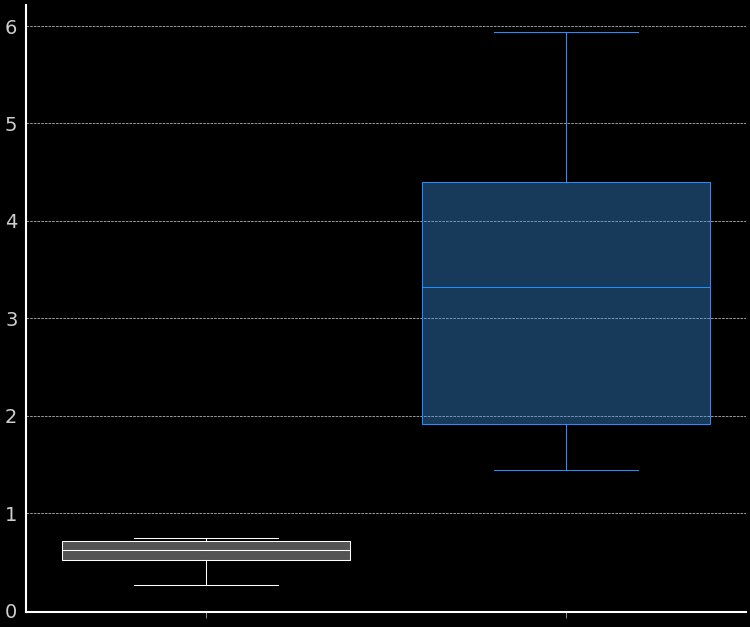

In [178]:
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots_dark.mplstyle')
sd_dex_means = sd_dex_means.loc[sd_dex_means['subject']!='ACR_14']
f, ax = plt.subplots(figsize=(18, 15), sharey=True)

sns.boxplot(
            x='store', 
            y='Bandpower',
            data=sd_dex_means.loc[sd_dex_means['store']=='NNXr'].exp_als('swi'),
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax,
            medianprops={"color": "white", "linewidth": 1.5},
            whiskerprops={"color": "white", "linewidth": 1.5},
            capprops={"color": "white", "linewidth": 1.5},
            boxprops={"edgecolor": "white", "linewidth": 1.5},
            )

sns.boxplot(
            x='store', 
            y='Bandpower',
            data=sd_dex_means.loc[sd_dex_means['store']=='NNXo'].exp_als('swi'),
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax,
            medianprops={"color": "dodgerblue", "linewidth": 1.5},
            whiskerprops={"color": "dodgerblue", "linewidth": 1.5},
            capprops={"color": "dodgerblue", "linewidth": 1.5},
            boxprops={"edgecolor": "dodgerblue", "linewidth": 1.5},
            )

for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))



#sns.swarmplot(data=sd_dex_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#e7dede', '#002aff'], marker='o', size=13, ax=ax)
#sns.lineplot(data=sd_dex_means.exp_als('swi'), x='store', y='Bandpower', units='subject', estimator=None, color='#7efff6', ax=ax, linewidth=2)

ax.set_xticklabels(['', ''])
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_title('OFF-Induction', fontsize=24)
#ax.set_ylabel('SWA (delta) as % of Baseline NREM Mean')

/tmp/ipykernel_2524961/4223577809.py:40: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=sd_dex_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#e7dede', '#002aff'], marker='o', size=13, ax=ax)


Text(66.3888888888889, 0.5, '')

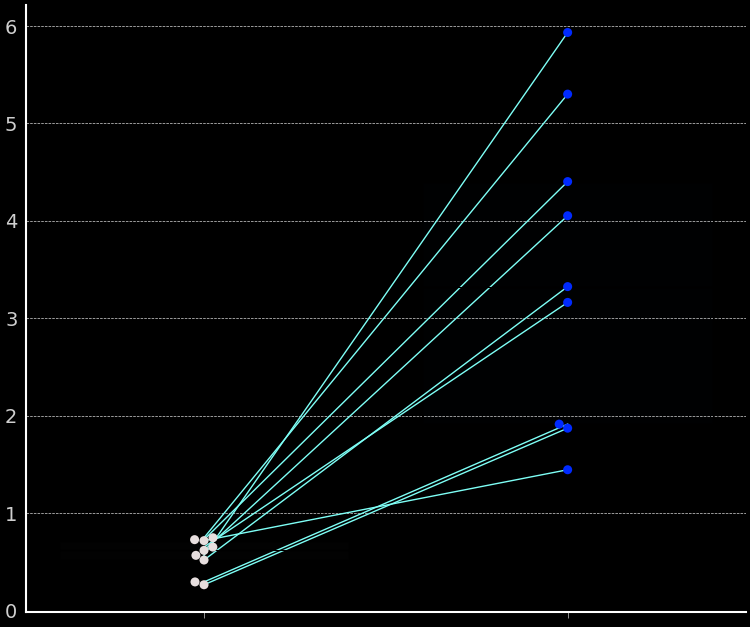

In [177]:
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots_dark.mplstyle')
sd_dex_means = sd_dex_means.loc[sd_dex_means['subject']!='ACR_14']
f, ax = plt.subplots(figsize=(18, 15), sharey=True)

sns.boxplot(
            x='store', 
            y='Bandpower',
            data=sd_dex_means.loc[sd_dex_means['store']=='NNXr'].exp_als('swi'),
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax,
            medianprops={"color": "black", "linewidth": 1.5},
            whiskerprops={"color": "black", "linewidth": 1.5},
            capprops={"color": "black", "linewidth": 1.5},
            boxprops={"edgecolor": "black", "linewidth": 1.5},
            )

sns.boxplot(
            x='store', 
            y='Bandpower',
            data=sd_dex_means.loc[sd_dex_means['store']=='NNXo'].exp_als('swi'),
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax,
            medianprops={"color": "black", "linewidth": 1.5},
            whiskerprops={"color": "black", "linewidth": 1.5},
            capprops={"color": "black", "linewidth": 1.5},
            boxprops={"edgecolor": "black", "linewidth": 1.5},
            )

for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .01))



sns.swarmplot(data=sd_dex_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#e7dede', '#002aff'], marker='o', size=13, ax=ax)
sns.lineplot(data=sd_dex_means.exp_als('swi'), x='store', y='Bandpower', units='subject', estimator=None, color='#7efff6', ax=ax, linewidth=2)

ax.set_xticklabels(['', ''])
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_title('OFF-Induction', fontsize=24)
#ax.set_ylabel('SWA (delta) as % of Baseline NREM Mean')

## Statistics

In [51]:
delta_during_swi_nnxr = sd_dex_means.loc[sd_dex_means.store=='NNXr'].exp_als('swi').sort_values('subject')['Bandpower'].to_numpy()
delta_during_swi_nnxo = sd_dex_means.loc[sd_dex_means.store=='NNXo'].exp_als('swi').sort_values('subject')['Bandpower'].to_numpy()

In [52]:
delta_during_swisin_nnxr = sd_dex_means.loc[sd_dex_means.store=='NNXr'].exp_als('swisin').sort_values('subject')['Bandpower'].to_numpy()
delta_during_swisin_nnxo = sd_dex_means.loc[sd_dex_means.store=='NNXo'].exp_als('swisin').sort_values('subject')['Bandpower'].to_numpy()

In [53]:
pg.ttest(delta_during_swi_nnxr, delta_during_swi_nnxo, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.714437,9,two-sided,0.001098,"[-4.73, -1.66]",1.922793,37.809,0.999653


In [54]:
pg.ttest(delta_during_swisin_nnxr, delta_during_swisin_nnxo, paired=True)

/home/kdriessen/miniconda3/envs/acrnew/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:7321: RuntimeWarning: divide by zero encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/home/kdriessen/miniconda3/envs/acrnew/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:7313: RuntimeWarning: divide by zero encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.38439,3,two-sided,0.726318,"[-1.54, 1.96]",0.22806,0.455,0.062725


# SWA differences during Rebound

In [7]:
reb_df = pl.read_csv('data/reb_df.csv')

## SWA

### Experimental

In [8]:
delta_exp = reb_df.filter(pl.col('Band')=='delta').st('NREM').filter(pl.col('exp_type')!='control')
delta_exp_means = delta_exp.groupby(['subject', 'exp', 'store']).mean().sort('Bandpower')
delta_exp_means = delta_exp_means.with_columns(exp_alias=pl.when(pl.col('exp')=='swi2').then('swi').otherwise(pl.col('exp'))) # this is an alias so that the swi2 experiments can be grouped with the swi experimental group
delta_exp_means = delta_exp_means.to_pandas()

# Need to do this so I can connect the individual data points within experiments, each two data points need their own subject number
sub_array = delta_exp_means['subject']
delta_exp_means['sub_alias'] = sub_array
for subject in delta_exp_means.expmt('swi2').subject.unique():
    delta_exp_means.loc[(delta_exp_means.subject == subject) & (delta_exp_means['exp'] == 'swi2'), 'sub_alias'] = f'{subject}_b'

/tmp/ipykernel_2524961/1320200527.py:3: DeprecationWarning: in a future version, string input will be parsed as a column name rather than a string literal. To silence this warning, pass the input as an expression instead: `pl.lit('swi')`
  delta_exp_means = delta_exp_means.with_columns(exp_alias=pl.when(pl.col('exp')=='swi2').then('swi').otherwise(pl.col('exp'))) # this is an alias so that the swi2 experiments can be grouped with the swi experimental group


/tmp/ipykernel_2524961/3316833438.py:20: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=delta_exp_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#e7dede', '#123aff'], marker='o', size=10, ax=ax[0])
/tmp/ipykernel_2524961/3316833438.py:34: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=delta_exp_means.exp_als('swisin'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#e7dede', '#123aff'], marker='o', size=10, ax=ax[1])


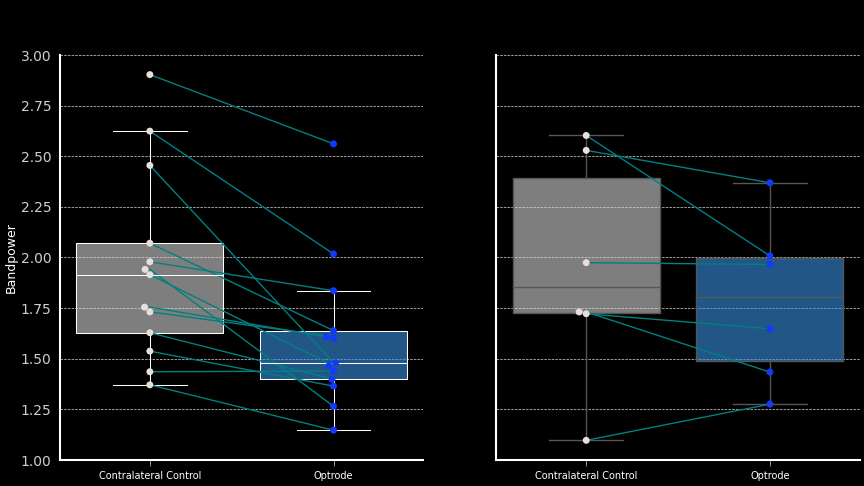

In [56]:
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots_dark.mplstyle')

f, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# OFF-INDUCTION
ax[0] = sns.boxplot(data=delta_exp_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['lightgray', 'dodgerblue'], fliersize=0, ax=ax[0],
                    medianprops={"color": "white", "linewidth": 1.5},
                    whiskerprops={"color": "white", "linewidth": 1.5},
                    capprops={"color": "white", "linewidth": 1.5},
                    boxprops={"edgecolor": "white", "linewidth": 1.5})

for patch in ax[0].patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))
    #patch.set_edgecolor('white')



sns.swarmplot(data=delta_exp_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#e7dede', '#123aff'], marker='o', size=10, ax=ax[0])
sns.lineplot(data=delta_exp_means.exp_als('swi'), x='store', y='Bandpower', units='sub_alias', estimator=None, color='teal', ax=ax[0], linewidth=2)

ax[0].set_xticklabels(['Contralateral Control', 'Optrode'])
ax[0].set_xlabel('')
#ax[0].set_title('OFF-Induction', fontsize=24)
#ax[0].set_ylabel('SWA (delta) as % of Baseline NREM Mean')

# SINUSOIDAL
sns.boxplot(data=delta_exp_means.exp_als('swisin'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['lightgray', 'dodgerblue'], fliersize=0, ax=ax[1])
for patch in ax[1].patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))

sns.swarmplot(data=delta_exp_means.exp_als('swisin'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#e7dede', '#123aff'], marker='o', size=10, ax=ax[1])
sns.lineplot(data=delta_exp_means.exp_als('swisin'), x='store', y='Bandpower', units='sub_alias', estimator=None, color='teal', ax=ax[1], linewidth=2)

ax[1].set_xticklabels(['Contralateral Control', 'Optrode'])
ax[1].set_xlabel('')
#ax[1].set_title('Sinusoidal', fontsize=24)
ax[1].set_ylabel('')


# FIGURE-LEVEL
f.suptitle('SWA During 1-Hour NREM Rebound (Delta)')
ax[0].set_ylim(1.0, 3.0)
ax[1].set_ylim(1.0, 3.0)

f.savefig(f'{figs}/swa_reb.png', dpi=600, bbox_inches='tight')

In [15]:
# Statistical tests
# -----------------

delta_reb_swi_nnxr = delta_exp_means.loc[delta_exp_means.store=='NNXr'].exp_als('swi').sort_values('subject')['Bandpower'].to_numpy()
delta_reb_swi_nnxo = delta_exp_means.loc[delta_exp_means.store=='NNXo'].exp_als('swi').sort_values('subject')['Bandpower'].to_numpy()
delta_reb_swisin_nnxr = delta_exp_means.loc[delta_exp_means.store=='NNXr'].exp_als('swisin').sort_values('subject')['Bandpower'].to_numpy()
delta_reb_swisin_nnxo = delta_exp_means.loc[delta_exp_means.store=='NNXo'].exp_als('swisin').sort_values('subject')['Bandpower'].to_numpy()

swi_stats = pg.ttest(delta_reb_swi_nnxr, delta_reb_swi_nnxo, paired=True)
swisin_stats = pg.ttest(delta_reb_swisin_nnxr, delta_reb_swisin_nnxo, paired=True)

In [20]:
swi_stats

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.723192,12,two-sided,0.000494,"[0.19, 0.51]",0.829509,72.347,0.783847


In [21]:
swisin_stats

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.470131,5,two-sided,0.201481,"[-0.12, 0.44]",0.324287,0.787,0.100095


In [16]:
swi_rels = {}
for subject in delta_exp_means.exp_als('swi')['sub_alias'].unique():
    swa_rel = delta_exp_means.loc[delta_exp_means['sub_alias']==subject].exp_als('swi').prb('NNXo')['Bandpower'].values[0] / delta_exp_means.loc[delta_exp_means['sub_alias']==subject].exp_als('swi').prb('NNXr')['Bandpower'].values[0]
    swi_rels[subject] = swa_rel

In [17]:
swisin_rels = {}
for subject in delta_exp_means.exp_als('swisin')['sub_alias'].unique():
    swa_rel = delta_exp_means.loc[delta_exp_means['sub_alias']==subject].exp_als('swisin').prb('NNXo')['Bandpower'].values[0] / delta_exp_means.loc[delta_exp_means['sub_alias']==subject].exp_als('swisin').prb('NNXr')['Bandpower'].values[0]
    swisin_rels[subject] = swa_rel

In [18]:
swi_rels_array = np.array(list(swi_rels.values()))
swisin_rels_array = np.array(list(swisin_rels.values()))

In [19]:
cross_exp_stats = pg.ttest(swi_rels_array, swisin_rels_array, paired=False)
cross_exp_stats

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.710836,8.344206,two-sided,0.123919,"[-0.26, 0.04]",0.907132,1.091,0.410793


### Layer-specific

In [13]:
frontal = reb_df.filter(pl.col('region')=='frontal').filter(pl.col('Band')=='delta').st('NREM').filter(pl.col('exp_type')!='control').filter(pl.col('exp')=='swi')

In [19]:
parietal = reb_df.filter(pl.col('region')=='parietal').filter(pl.col('Band')=='delta').st('NREM').filter(pl.col('exp_type')!='control').filter(pl.col('exp')=='swi')

<Axes: xlabel='layer', ylabel='Bandpower'>

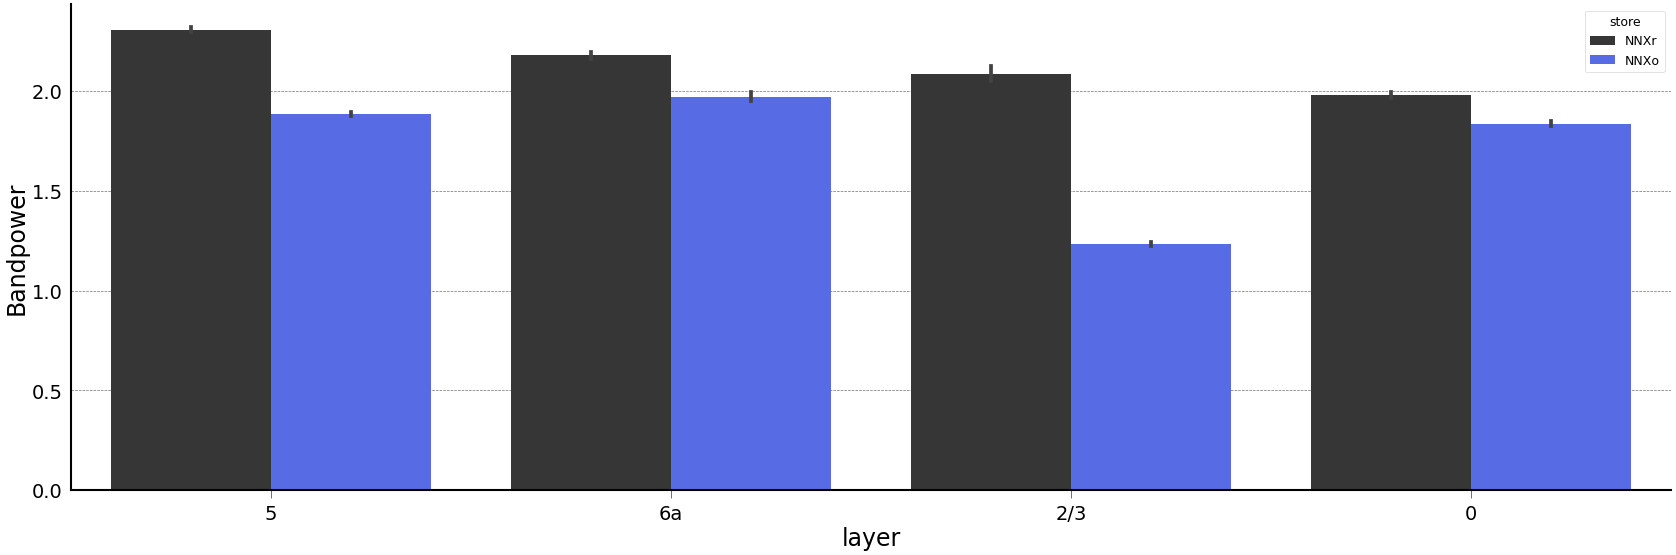

In [18]:
sns.barplot(frontal.to_pandas(), x='layer', y='Bandpower', hue='store')

<Axes: xlabel='layer', ylabel='Bandpower'>

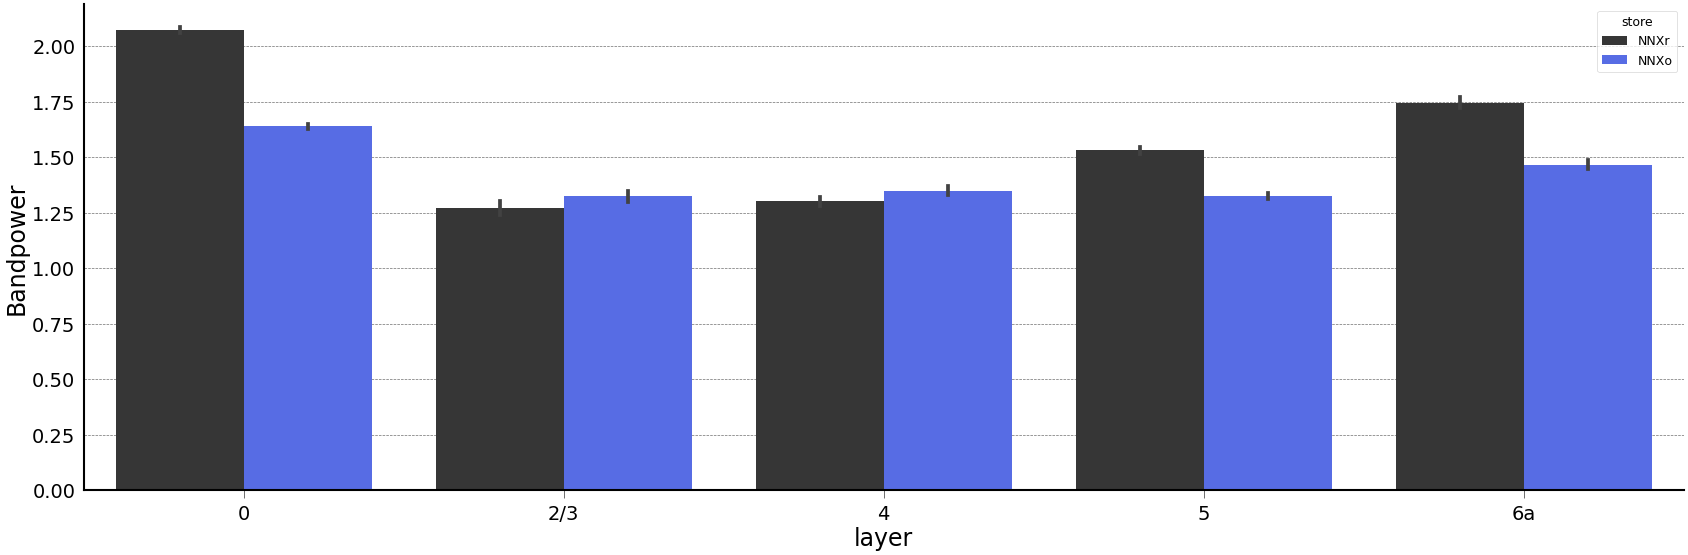

In [20]:
sns.barplot(parietal.to_pandas(), x='layer', y='Bandpower', hue='store')

### Controls

In [49]:
delta_ctrl = reb_df.filter(pl.col('Band')=='delta').st('NREM').filter(pl.col('exp_type')=='control')
delta_ctrl_means = delta_ctrl.groupby(['subject', 'exp', 'store']).mean().sort('Bandpower')
delta_ctrl_means = delta_ctrl_means.with_columns(exp_alias=pl.when(pl.col('exp')=='swi2').then('swi').otherwise(pl.col('exp'))) # this is an alias so that the swi2 experiments can be grouped with the swi experimental group
delta_ctrl_means = delta_ctrl_means.to_pandas()

# Need to do this so I can connect the individual data points within experiments, each two data points need their own subject number
sub_array = delta_ctrl_means['subject']
delta_ctrl_means['sub_alias'] = sub_array
for subject in delta_ctrl_means.expmt('swi2').subject.unique():
    delta_ctrl_means.loc[(delta_ctrl_means.subject == subject) & (delta_ctrl_means['exp'] == 'swi2'), 'sub_alias'] = f'{subject}_b'

/tmp/ipykernel_1769652/1923202248.py:3: DeprecationWarning: in a future version, string input will be parsed as a column name rather than a string literal. To silence this warning, pass the input as an expression instead: `pl.lit('swi')`
  delta_ctrl_means = delta_ctrl_means.with_columns(exp_alias=pl.when(pl.col('exp')=='swi2').then('swi').otherwise(pl.col('exp'))) # this is an alias so that the swi2 experiments can be grouped with the swi experimental group


/tmp/ipykernel_1769652/2799239636.py:10: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=delta_ctrl_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['black', 'blue'], marker='o', size=18, ax=ax[0])
/tmp/ipykernel_1769652/2799239636.py:24: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=delta_ctrl_means.exp_als('swisin'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['black', 'blue'], marker='o', size=18, ax=ax[1])


(1.0, 3.0)

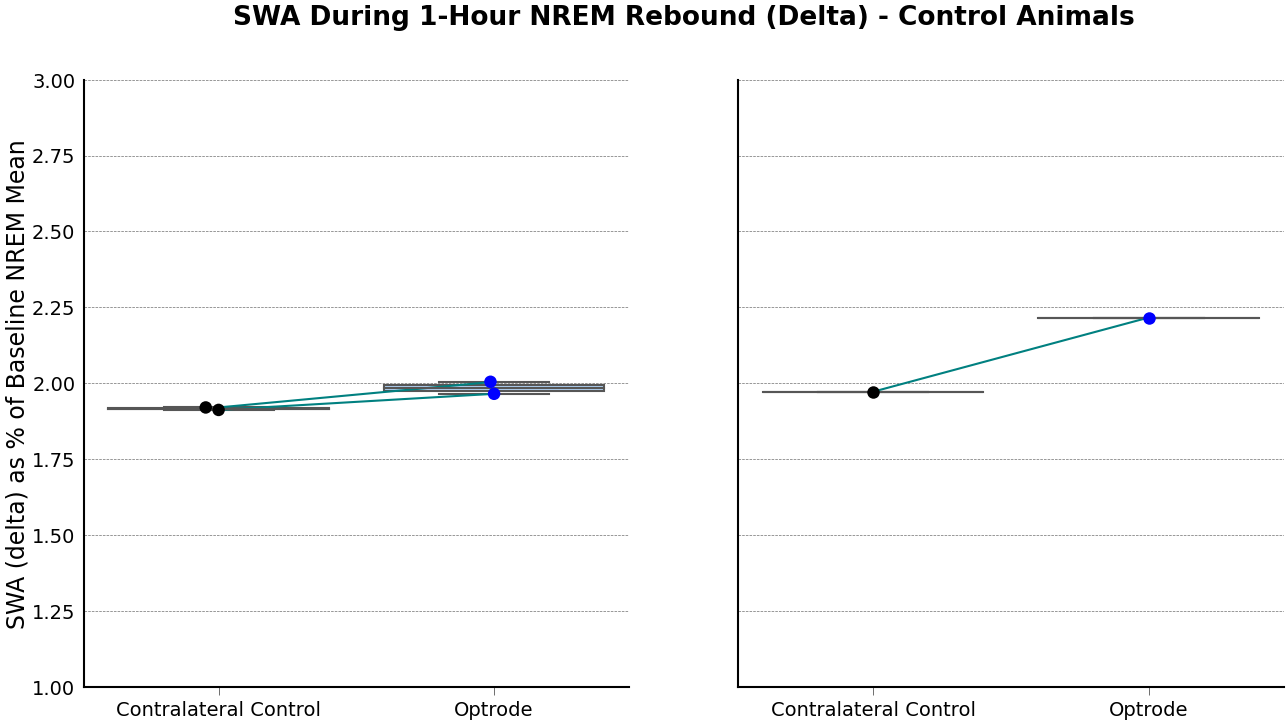

In [25]:
f, ax = plt.subplots(1, 2, figsize=(30, 15), sharey=True)


# OFF-INDUCTION
sns.boxplot(data=delta_ctrl_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['lightgray', 'dodgerblue'], fliersize=0, ax=ax[0])
for patch in ax[0].patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

sns.swarmplot(data=delta_ctrl_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['black', 'blue'], marker='o', size=18, ax=ax[0])
sns.lineplot(data=delta_ctrl_means.exp_als('swi'), x='store', y='Bandpower', units='sub_alias', estimator=None, color='teal', ax=ax[0], linewidth=3)

ax[0].set_xticklabels(['Contralateral Control', 'Optrode'])
ax[0].set_xlabel('')
#ax[0].set_title('OFF-Induction', fontsize=24)
ax[0].set_ylabel('SWA (delta) as % of Baseline NREM Mean')

# SINUSOIDAL
sns.boxplot(data=delta_ctrl_means.exp_als('swisin'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['lightgray', 'dodgerblue'], fliersize=0, ax=ax[1])
for patch in ax[1].patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

sns.swarmplot(data=delta_ctrl_means.exp_als('swisin'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['black', 'blue'], marker='o', size=18, ax=ax[1])
sns.lineplot(data=delta_ctrl_means.exp_als('swisin'), x='store', y='Bandpower', units='sub_alias', estimator=None, color='teal', ax=ax[1], linewidth=3)

ax[1].set_xticklabels(['Contralateral Control', 'Optrode'])
ax[1].set_xlabel('')
#ax[1].set_title('Sinusoidal', fontsize=24)
ax[1].set_ylabel('')


# FIGURE-LEVEL
f.suptitle('SWA During 1-Hour NREM Rebound (Delta) - Control Animals')
ax[0].set_ylim(1.0, 3.0)
ax[1].set_ylim(1.0, 3.0)

## All Bands

In [79]:
bp_exp = reb_df.st('NREM').filter(pl.col('exp_type')!='control')
bp_exp_means = bp_exp.groupby(['subject', "Band", 'exp', 'store']).mean().sort('Bandpower')
bp_exp_means = bp_exp_means.with_columns(exp_alias=pl.when(pl.col('exp')=='swi2').then('swi').otherwise(pl.col('exp'))) # this is an alias so that the swi2 experiments can be grouped with the swi experimental group
bp_exp_means = bp_exp_means.to_pandas()

# Need to do this so I can connect the individual data points within experiments, each two data points need their own subject number
sub_array = bp_exp_means['subject']
bp_exp_means['sub_alias'] = sub_array
for subject in bp_exp_means.expmt('swi2').subject.unique():
    bp_exp_means.loc[(bp_exp_means.subject == subject) & (bp_exp_means['exp'] == 'swi2'), 'sub_alias'] = f'{subject}_b'

/tmp/ipykernel_1769652/3840806719.py:3: DeprecationWarning: in a future version, string input will be parsed as a column name rather than a string literal. To silence this warning, pass the input as an expression instead: `pl.lit('swi')`
  bp_exp_means = bp_exp_means.with_columns(exp_alias=pl.when(pl.col('exp')=='swi2').then('swi').otherwise(pl.col('exp'))) # this is an alias so that the swi2 experiments can be grouped with the swi experimental group


(0.0, 3.5)

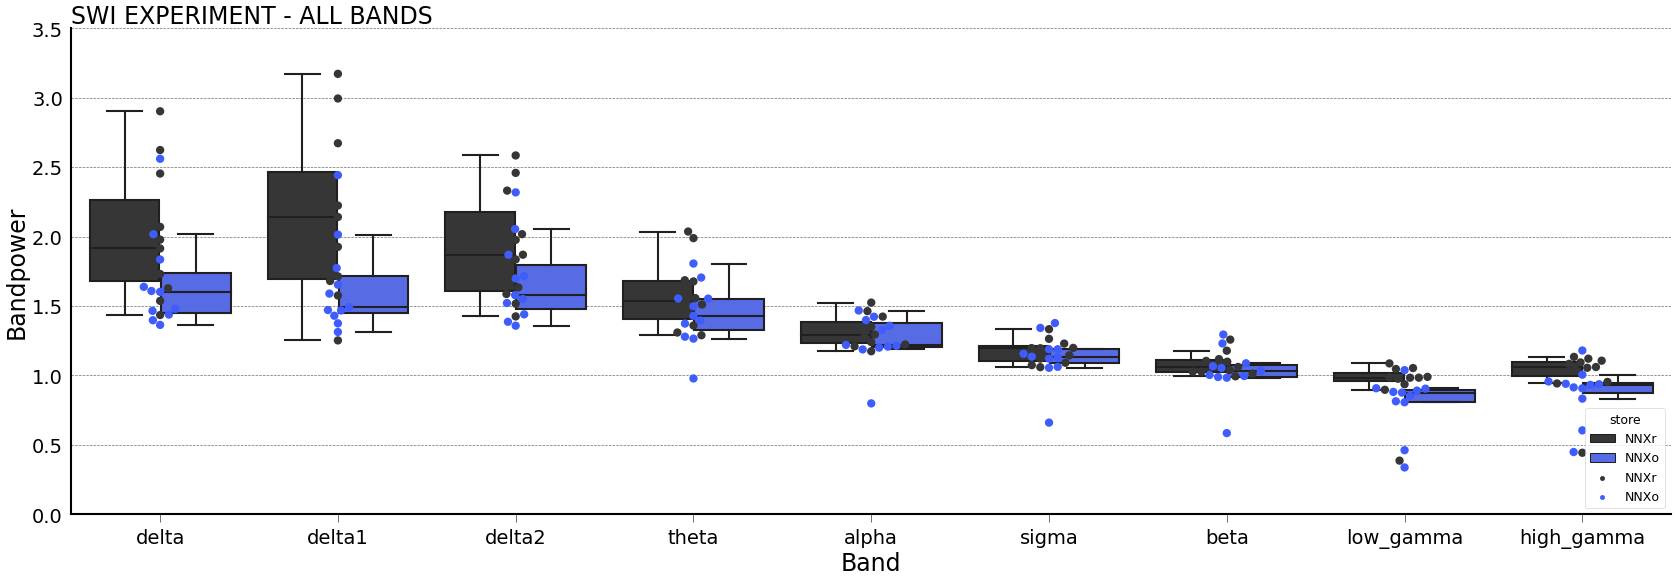

In [93]:
f, ax = plt.subplots()
sns.boxplot(data=bp_exp_means.exp_als('swi'), x='Band', y='Bandpower', hue='store', order=band_def, hue_order=['NNXr', 'NNXo'], fliersize=0, ax=ax)
sns.swarmplot(data=bp_exp_means.exp_als('swi'), x='Band', y='Bandpower', hue='store', order=band_def, hue_order=['NNXr', 'NNXo'], marker='o', size=12, ax=ax)
ax.set_title('SWI EXPERIMENT - ALL BANDS')
ax.set_ylim(0, 3.5)

(0.0, 3.5)

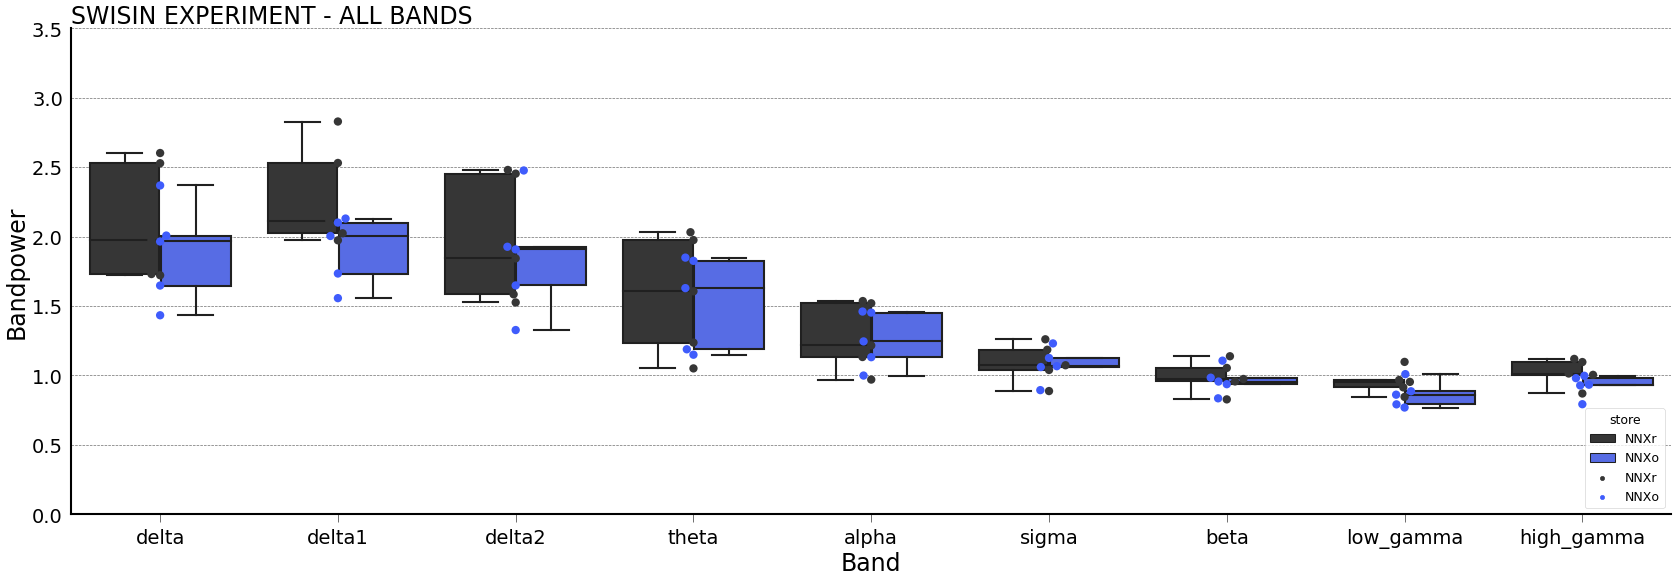

In [94]:
f, ax = plt.subplots()
sns.boxplot(data=bp_exp_means.exp_als('swisin'), x='Band', y='Bandpower', hue='store', order=band_def, hue_order=['NNXr', 'NNXo'], fliersize=0, ax=ax)
sns.swarmplot(data=bp_exp_means.exp_als('swisin'), x='Band', y='Bandpower', hue='store', order=band_def, hue_order=['NNXr', 'NNXo'], marker='o', size=12, ax=ax)
ax.set_title('SWISIN EXPERIMENT - ALL BANDS')
ax.set_ylim(0, 3.5)

/tmp/ipykernel_2524961/3164045726.py:41: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=delta_exp_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#e7dede', '#002aff'], marker='o', size=13, ax=ax)


Text(35.38888888888889, 0.5, '')

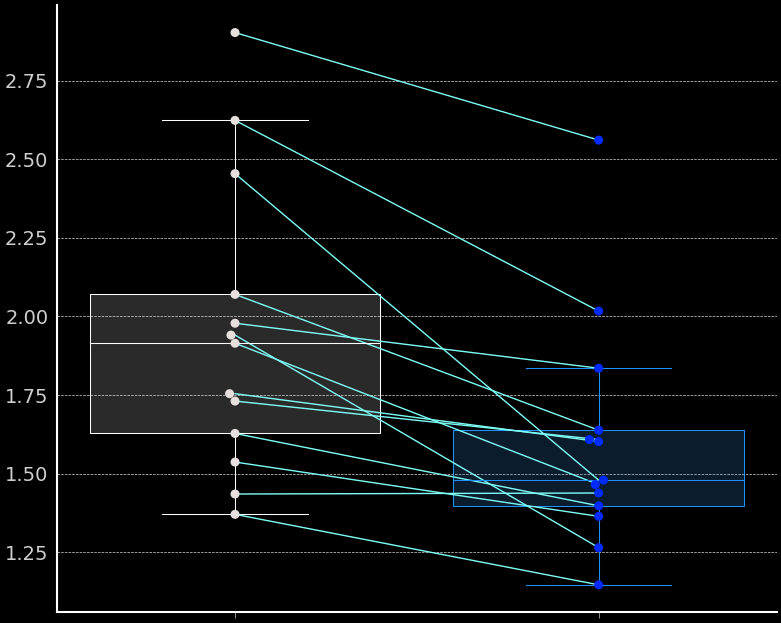

In [84]:
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots_dark.mplstyle')

f, ax = plt.subplots(1, 1, figsize=(18, 15), sharey=True)

sns.boxplot(
            x='store', 
            y='Bandpower',
            data=delta_exp_means.loc[delta_exp_means['store']=='NNXr'].exp_als('swi'),
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax,
            medianprops={"color": "white", "linewidth": 1.5},
            whiskerprops={"color": "white", "linewidth": 1.5},
            capprops={"color": "white", "linewidth": 1.5},
            boxprops={"edgecolor": "white", "linewidth": 1.5},
            )

sns.boxplot(
            x='store', 
            y='Bandpower',
            data=delta_exp_means.loc[delta_exp_means['store']=='NNXo'].exp_als('swi'),
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax,
            medianprops={"color": "dodgerblue", "linewidth": 1.5},
            whiskerprops={"color": "dodgerblue", "linewidth": 1.5},
            capprops={"color": "dodgerblue", "linewidth": 1.5},
            boxprops={"edgecolor": "dodgerblue", "linewidth": 1.5},
            )

for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))
    #patch.set_edgecolor('white')



sns.swarmplot(data=delta_exp_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#e7dede', '#002aff'], marker='o', size=13, ax=ax)
sns.lineplot(data=delta_exp_means.exp_als('swi'), x='store', y='Bandpower', units='sub_alias', estimator=None, color='#7efff6', ax=ax, linewidth=2)

ax.set_xticklabels(['', ''])
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_title('OFF-Induction', fontsize=24)
#ax.set_ylabel('SWA (delta) as % of Baseline NREM Mean')

Text(0, 0.5, '')

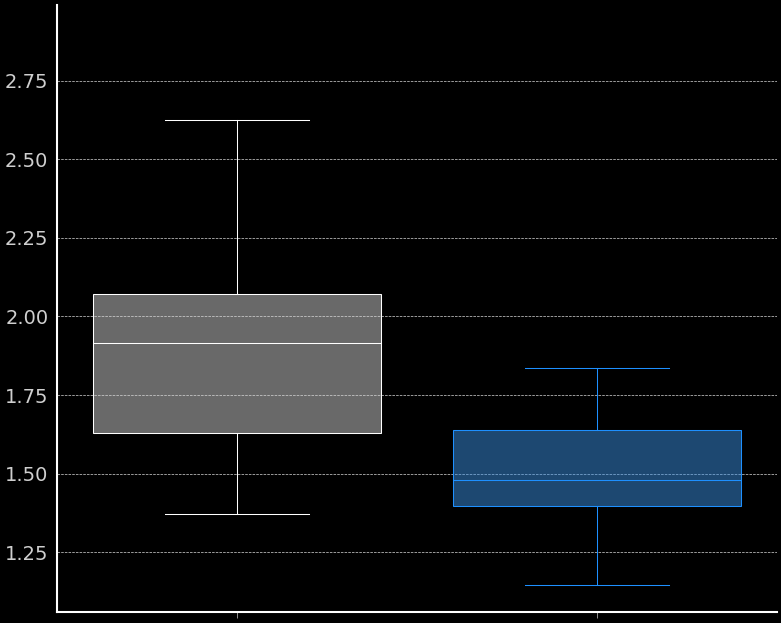

In [87]:
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots_dark.mplstyle')

f, ax = plt.subplots(1, 1, figsize=(18, 15), sharey=True)

sns.boxplot(
            x='store', 
            y='Bandpower',
            data=delta_exp_means.loc[delta_exp_means['store']=='NNXr'].exp_als('swi'),
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax,
            medianprops={"color": "white", "linewidth": 1.5},
            whiskerprops={"color": "white", "linewidth": 1.5},
            capprops={"color": "white", "linewidth": 1.5},
            boxprops={"edgecolor": "white", "linewidth": 1.5},
            )

sns.boxplot(
            x='store', 
            y='Bandpower',
            data=delta_exp_means.loc[delta_exp_means['store']=='NNXo'].exp_als('swi'),
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax,
            medianprops={"color": "dodgerblue", "linewidth": 1.5},
            whiskerprops={"color": "dodgerblue", "linewidth": 1.5},
            capprops={"color": "dodgerblue", "linewidth": 1.5},
            boxprops={"edgecolor": "dodgerblue", "linewidth": 1.5},
            )

for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .5))
    #patch.set_edgecolor('white')



#sns.swarmplot(data=delta_exp_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#e7dede', '#002aff'], marker='o', size=13, ax=ax)
#sns.lineplot(data=delta_exp_means.exp_als('swi'), x='store', y='Bandpower', units='sub_alias', estimator=None, color='#7efff6', ax=ax, linewidth=2)

ax.set_xticklabels(['', ''])
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_title('OFF-Induction', fontsize=24)
#ax.set_ylabel('SWA (delta) as % of Baseline NREM Mean')

/tmp/ipykernel_2524961/2266397051.py:41: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=delta_exp_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#e7dede', '#002aff'], marker='o', size=13, ax=ax)


Text(35.38888888888889, 0.5, '')

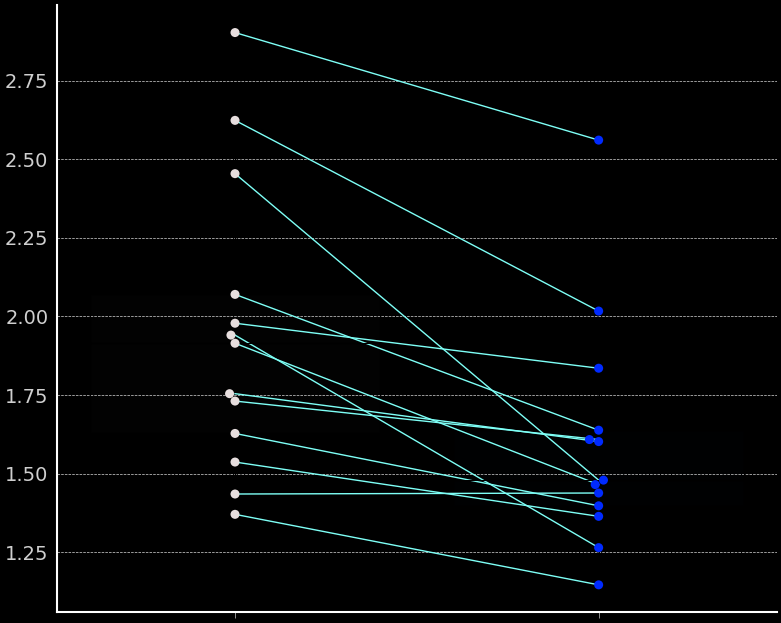

In [86]:
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots_dark.mplstyle')

f, ax = plt.subplots(1, 1, figsize=(18, 15), sharey=True)

sns.boxplot(
            x='store', 
            y='Bandpower',
            data=delta_exp_means.loc[delta_exp_means['store']=='NNXr'].exp_als('swi'),
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax,
            medianprops={"color": "black", "linewidth": 1.5},
            whiskerprops={"color": "black", "linewidth": 1.5},
            capprops={"color": "black", "linewidth": 1.5},
            boxprops={"edgecolor": "black", "linewidth": 1.5},
            )

sns.boxplot(
            x='store', 
            y='Bandpower',
            data=delta_exp_means.loc[delta_exp_means['store']=='NNXo'].exp_als('swi'),
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax,
            medianprops={"color": "black", "linewidth": 1.5},
            whiskerprops={"color": "black", "linewidth": 1.5},
            capprops={"color": "black", "linewidth": 1.5},
            boxprops={"edgecolor": "black", "linewidth": 1.5},
            )

for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .01))
    #patch.set_edgecolor('white')



sns.swarmplot(data=delta_exp_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['#e7dede', '#002aff'], marker='o', size=13, ax=ax)
sns.lineplot(data=delta_exp_means.exp_als('swi'), x='store', y='Bandpower', units='sub_alias', estimator=None, color='#7efff6', ax=ax, linewidth=2)

ax.set_xticklabels(['', ''])
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_title('OFF-Induction', fontsize=24)
#ax.set_ylabel('SWA (delta) as % of Baseline NREM Mean')

In [ ]:
# OFF-INDUCTION
sns.boxplot(
            x='store', 
            y='Bandpower',
            data=delta_exp_means.loc[delta_exp_means['store']=='NNXr'].exp_als('swi'),
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax,
            medianprops={"color": "white", "linewidth": 1.5},
            whiskerprops={"color": "white", "linewidth": 1.5},
            capprops={"color": "white", "linewidth": 1.5},
            boxprops={"edgecolor": "white", "linewidth": 1.5},
            )

sns.boxplot(
            x='store', 
            y='Bandpower',
            data=delta_exp_means.loc[delta_exp_means['store']=='NNXo'].exp_als('swi'),
            order=['NNXr', 'NNXo'], 
            palette=['lightgray', 'dodgerblue'], 
            fliersize=0, 
            ax=ax,
            medianprops={"color": "dodgerblue", "linewidth": 1.5},
            whiskerprops={"color": "dodgerblue", "linewidth": 1.5},
            capprops={"color": "dodgerblue", "linewidth": 1.5},
            boxprops={"edgecolor": "dodgerblue", "linewidth": 1.5},
            )


In [77]:
# 13 experiments in 10 subjects